In [1]:
import os
import random
from itertools import combinations

import editdistance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import Dataset, load_dataset
from llms.dna_translator.gpt import DNATranslatorGPT
from pandas import DataFrame
from schemas.train_params import TrainParams
from tqdm import tqdm

# Limits

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [3]:
SEED = 42

# Minimal Dataset

In [4]:
dataset = load_dataset("GustavoHCruz/DNA_Coding_Regions", split="train")

assert isinstance(dataset, Dataset)

dataset = dataset.to_pandas()

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

In [5]:
def join_proteins(protein_list) -> str:
	seqs = []
	for p in protein_list:
		seq = p.get("sequence", "")
		if isinstance(seq, str):
			seqs.append(seq)
	return "".join(seqs)

In [6]:
assert isinstance(dataset, DataFrame)

dataset["target"] = dataset["proteins"].apply(join_proteins).astype(str)
mask = (dataset["sequence"].str.len() + dataset["target"].str.len()) < 1000
original_df = dataset[mask]
original_df = original_df[["sequence", "target", "organism"]]

original_df

,sequence,target,organism
12,GACTTGAAGGACATGATTGGCTGTGGATTCTGACATCCACCATCTT...,AIY,Solenangis impraedicta
13,CGACTTGAAGGACATGATTGGCTGTGGATTCTGACATCCACCATCT...,AIYRIVA,Rhipidoglossum stolzii
14,TGAAGGACATGATTGGCTGTGGATTCTGACATCCACCATCTTCTAT...,AIYRIV,Rhipidoglossum curvatum
15,TGAAGGACATGATTGGCTGTGGATTCTGACATCCACCATCTTCTAT...,AIYRIV,Rhipidoglossum burttii
16,AGGACATGATTGGCTGTGGATTTTGACATCCACCATCTTCTATACG...,AIYRIVA,Mystacidium braybonae
...,...,...,...
1677598,GAAGGTTTGGTCCTGTCCTGTCCTGTCTGACAGTGTAATCACATAT...,KTTPPSVYPLAPGSPSETVTCNVAHPASSTKVDKKIVPRDCGCKPC...,Mus musculus
1677599,CTGCAGGTGTCACAGTTCCTTTCACTGACTGCCATTCTGGAGCATT...,RFLEQLKAECHYFNGKERVWSVTRFIYNQEEFARFNSDFGKFLAVT...,Mus musculus
1677600,AAGCTTGCTGAAGCGTTTCTGTCTGAGTTTCATAATCCAATAGTTT...,IYSSDEDDEDIEMCDHDYDGLLPKSGKRHLGKTRWTREE,Mus musculus
1677603,AGGGCAGGGGGTTACACTTAAAAATTAGCATTATACTTAGTTCGAT...,MHNNENVSGISAYLLGLIIGDGGLYKLKYKGNRSEYRVVITQKSEN...,Desulfurococcus mucosus


In [7]:
print("Final Length of Dataset: ", len(original_df))

Final Length of Dataset:  244090


# Removing Invalid

In [8]:
len(original_df)

244090

In [9]:
original_df = original_df[original_df["sequence"].str.len().ge(2)]

In [10]:
len(original_df)

244090

# How Many Trivial?

In [11]:
CODON_TABLE = {
	'TTT':'F','TTC':'F','TTA':'L','TTG':'L',
	'CTT':'L','CTC':'L','CTA':'L','CTG':'L',
	'ATT':'I','ATC':'I','ATA':'I','ATG':'M',
	'GTT':'V','GTC':'V','GTA':'V','GTG':'V',
	'TCT':'S','TCC':'S','TCA':'S','TCG':'S',
	'CCT':'P','CCC':'P','CCA':'P','CCG':'P',
	'ACT':'T','ACC':'T','ACA':'T','ACG':'T',
	'GCT':'A','GCC':'A','GCA':'A','GCG':'A',
	'TAT':'Y','TAC':'Y','TAA':'*','TAG':'*',
	'CAT':'H','CAC':'H','CAA':'Q','CAG':'Q',
	'AAT':'N','AAC':'N','AAA':'K','AAG':'K',
	'GAT':'D','GAC':'D','GAA':'E','GAG':'E',
	'TGT':'C','TGC':'C','TGA':'*','TGG':'W',
	'CGT':'R','CGC':'R','CGA':'R','CGG':'R',
	'AGT':'S','AGC':'S','AGA':'R','AGG':'R',
	'GGT':'G','GGC':'G','GGA':'G','GGG':'G'
}

def translate_frame(seq, frame):
	protein = []
	for i in range(frame, len(seq) - 2, 3):
		codon = seq[i:i+3]
		protein.append(CODON_TABLE.get(codon, 'X'))
	return ''.join(protein)

def protein_segments(protein):
	return [seg for seg in protein.split('*') if len(seg) > 0]

def similarity(a, b):
	if len(a) == 0 or len(b) == 0:
		return 0.0
	dist = editdistance.eval(a, b)
	return 1.0 - dist / max(len(a), len(b))

In [12]:
TRIVIAL_THRESHOLD = 0.8
AMBIGUOUS_THRESHOLD = 0.65

In [13]:
max_similarities = []

for _, row in tqdm(original_df.iterrows(), total=len(original_df)):
	dna = row["sequence"].upper()
	target = row["target"]

	best = 0.0

	for frame in (0, 1, 2):
		protein = translate_frame(dna, frame)
		segments = protein_segments(protein)

		for seg in segments:
			sim = similarity(seg, target)
			if sim > best:
				best = sim

	max_similarities.append(best)

original_df["max_frame_similarity"] = max_similarities

100%|██████████| 244090/244090 [00:40<00:00, 5963.64it/s]


In [14]:
def classify(sim):
	if sim >= TRIVIAL_THRESHOLD:
		return "trivial"
	elif sim >= AMBIGUOUS_THRESHOLD:
		return "ambiguous"
	else:
		return "genomic"

original_df["translation_class"] = original_df["max_frame_similarity"].apply(classify)

In [15]:
print("Distribution:")
print(original_df["translation_class"].value_counts())

Distribution:
translation_class
genomic      154191
trivial       60266
ambiguous     29633
Name: count, dtype: int64


In [16]:
print("Percentils:")
print(original_df["translation_class"].value_counts(normalize=True) * 100)

Percentils:
translation_class
genomic      63.169732
trivial      24.690073
ambiguous    12.140194
Name: proportion, dtype: float64


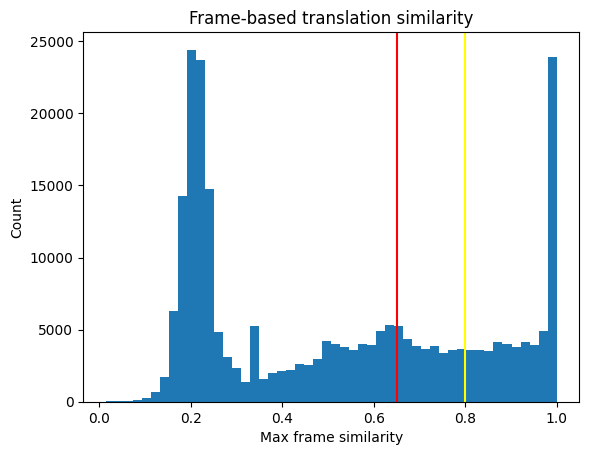

In [17]:
plt.figure()
plt.hist(original_df["max_frame_similarity"], bins=50)
plt.axvline(TRIVIAL_THRESHOLD, color="yellow")
plt.axvline(AMBIGUOUS_THRESHOLD, color="red")
plt.xlabel("Max frame similarity")
plt.ylabel("Count")
plt.title("Frame-based translation similarity")
plt.show()

In [18]:
genomic = original_df[original_df["translation_class"] == "genomic"]
ambiguous = original_df[original_df["translation_class"] == "ambiguous"]
trivial = original_df[original_df["translation_class"] == "trivial"]

In [19]:
print(f"Genomics: {len(genomic)} ({len(genomic)/len(original_df)*100:.2f}%)")
print(f"Other (trivial + ambiguous): {len(ambiguous) + len(trivial)} ({(len(ambiguous) + len(trivial))/len(original_df)*100:.2f}%)")

Genomics: 154191 (63.17%)
Other (trivial + ambiguous): 89899 (36.83%)


# Data Structure & Analysis

In [20]:
stats = genomic.copy()

stats["organism_norm"] = (
	stats["organism"]
	.astype(str)
	.str.strip()
	.str.lower()
)

print(f"Total of Sequences: {len(stats)}")
print(f"Total of Species: {stats['organism_norm'].nunique()}")

Total of Sequences: 154191
Total of Species: 10491


In [21]:
species_stats = (
	stats
	.groupby("organism_norm")
	.agg(
		num_sequences=("sequence", "count"),
		avg_seq_length=("sequence", lambda x: x.str.len().mean())
	)
	.reset_index()
)

In [22]:
print("Number of sequences per species:")
print(species_stats["num_sequences"].describe())

Number of sequences per species:
count    10491.000000
mean        14.697455
std        332.340777
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      25633.000000
Name: num_sequences, dtype: float64


In [23]:
print("Average sequence size by species:")
print(species_stats["avg_seq_length"].describe())

Average sequence size by species:
count    10491.000000
mean       664.181832
std        200.332992
min         80.000000
25%        521.000000
50%        682.000000
75%        852.000000
max        996.000000
Name: avg_seq_length, dtype: float64


In [24]:
print("Species with MORE sequences:")
print(species_stats.loc[species_stats["num_sequences"].idxmax()])

Species with MORE sequences:
organism_norm     rotaria magnacalcarata
num_sequences                      25633
avg_seq_length                459.185581
Name: 8592, dtype: object


In [25]:
print("Species with FEWER sequences:")
print(species_stats.loc[species_stats["num_sequences"].idxmin()])

Species with FEWER sequences:
organism_norm     [ballota] hirsuta subsp. intermedia
num_sequences                                       1
avg_seq_length                                  851.0
Name: 0, dtype: object


# Similarity Check

In [26]:
MAX_PAIRS_PER_SPECIES = 500
MAX_INTERSPECIES_PAIRS = 50000

In [27]:
random.seed(SEED)

In [28]:
def dna_similarity(a, b):
	if len(a) == 0 or len(b) == 0:
		return 0.0
	dist = editdistance.eval(a, b)
	return 1.0 - dist / max(len(a), len(b))

In [29]:
intra_results = []

for organism, group in tqdm(genomic.groupby("organism"), desc="Intra-species"):
	sequences = group["sequence"].tolist()

	if len(sequences) < 2:
		continue

	pairs = list(combinations(sequences, 2))
	random.shuffle(pairs)
	pairs = pairs[:MAX_PAIRS_PER_SPECIES]

	for a, b in pairs:
		sim = dna_similarity(a, b)
		intra_results.append({
			"organism": organism,
			"similarity": sim
		})

Intra-species: 100%|██████████| 10491/10491 [07:30<00:00, 23.31it/s] 


In [30]:
intra_df = pd.DataFrame(intra_results)

print("INTRA-SPECIES")
print(intra_df["similarity"].describe())

INTRA-SPECIES
count    144999.000000
mean          0.710914
std           0.255095
min           0.037554
25%           0.477306
50%           0.714083
75%           0.982895
max           0.998996
Name: similarity, dtype: float64


In [31]:
organisms = genomic["organism"].unique().tolist()
inter_results = []

pairs_done = 0

for org_a, org_b in tqdm(list(combinations(organisms, 2)), desc="Inter-species"):
	if pairs_done >= MAX_INTERSPECIES_PAIRS:
		break

	seqs_a = genomic[genomic["organism"] == org_a]["sequence"].tolist()
	seqs_b = genomic[genomic["organism"] == org_b]["sequence"].tolist()

	if not seqs_a or not seqs_b:
		continue

	a = random.choice(seqs_a)
	b = random.choice(seqs_b)

	sim = dna_similarity(a, b)
	inter_results.append({
		"organism_a": org_a,
		"organism_b": org_b,
		"similarity": sim
	})

	pairs_done += 1

Inter-species:   0%|          | 50000/55025295 [09:46<179:02:55, 85.29it/s]


In [32]:
inter_df = pd.DataFrame(inter_results)

print("INTER-SPECIES")
print(inter_df["similarity"].describe())

INTER-SPECIES
count    50000.000000
mean         0.448958
std          0.064333
min          0.051125
25%          0.432852
50%          0.464646
75%          0.486239
max          0.988827
Name: similarity, dtype: float64


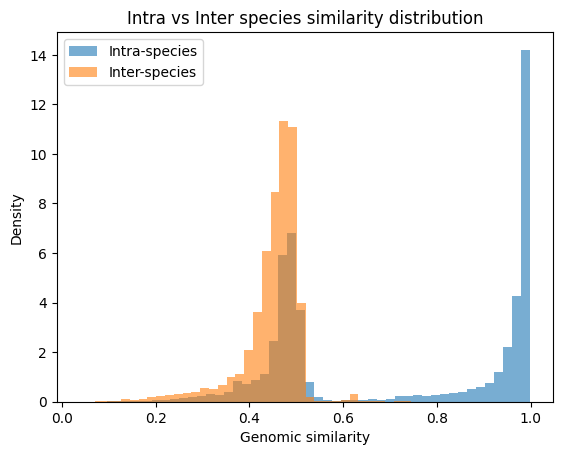

In [33]:
plt.figure()
plt.hist(
	intra_df["similarity"],
	bins=50,
	alpha=0.6,
	label="Intra-species",
	density=True
)
plt.hist(
	inter_df["similarity"],
	bins=50,
	alpha=0.6,
	label="Inter-species",
	density=True
)

plt.xlabel("Genomic similarity")
plt.ylabel("Density")
plt.legend()
plt.title("Intra vs Inter species similarity distribution")
plt.show()


# Splitting Things

In [34]:
def split_by_organism(
	df,
	seed=SEED,
	train_ratio=0.85,
	test_ratio=0.10,
	val_ratio=0.05
):
	assert abs(train_ratio + test_ratio + val_ratio - 1.0) < 1e-6

	random.seed(seed)
	np.random.seed(seed)

	organisms = df["organism"].unique().tolist()
	random.shuffle(organisms)

	n_orgs = len(organisms)

	n_train = int(n_orgs * train_ratio)
	n_test = int(n_orgs * test_ratio)

	train_orgs = set(organisms[:n_train])
	test_orgs = set(organisms[n_train:n_train + n_test])
	val_orgs = set(organisms[n_train + n_test:])

	train_df = df[df["organism"].isin(train_orgs)].reset_index(drop=True)
	test_df = df[df["organism"].isin(test_orgs)].reset_index(drop=True)
	val_df = df[df["organism"].isin(val_orgs)].reset_index(drop=True)

	print("=" * 60)
	print(f"Seed: {seed}")
	print(f"Total organisms: {n_orgs}")
	print()
	print("Organism split:")
	print(f"  Train: {len(train_orgs)} organisms")
	print(f"  Test : {len(test_orgs)} organisms")
	print(f"  Val  : {len(val_orgs)} organisms")
	print()
	print("Sequence split:")
	print(f"  Train: {len(train_df)} sequences")
	print(f"  Test : {len(test_df)} sequences")
	print(f"  Val  : {len(val_df)} sequences")
	print()
	print("Approximate ratios (by sequence):")
	total_seq = len(df)
	print(f"  Train: {len(train_df)/total_seq:.3f}")
	print(f"  Test : {len(test_df)/total_seq:.3f}")
	print(f"  Val  : {len(val_df)/total_seq:.3f}")
	print("=" * 60)

	return train_df, test_df, val_df

In [35]:
train_df, test_df, val_df = split_by_organism(
	genomic,
	seed=SEED
)

Seed: 42
Total organisms: 10491

Organism split:
  Train: 8917 organisms
  Test : 1049 organisms
  Val  : 525 organisms

Sequence split:
  Train: 144384 sequences
  Test : 8342 sequences
  Val  : 1465 sequences

Approximate ratios (by sequence):
  Train: 0.936
  Test : 0.054
  Val  : 0.010


# Training To Generate

In [36]:
llm = DNATranslatorGPT(
  checkpoint="./storage/models/base/gpt2",
  seed=SEED
)

In [37]:
train_data = train_df.to_dict(orient="records")
test_data = test_df.to_dict(orient="records")
val_data = val_df.to_dict(orient="records")

In [38]:
train_dataset = []
for record in tqdm(train_data, desc="Train Data"):
	example = llm.build_input(
		dna_sequence=record["sequence"],
		organism=record["organism"],
		protein_sequence=record["target"]
	)
	train_dataset.append(example)

test_dataset = []
for record in tqdm(test_data, desc="Test Data"):
	example = llm.build_input(
		dna_sequence=record["sequence"],
		organism=record["organism"],
		protein_sequence=record["target"]
	)
	test_dataset.append(example)

eval_dataset = []
for record in tqdm(val_data, desc="Eval Data"):
	example = llm.build_input(
		dna_sequence=record["sequence"],
		organism=record["organism"],
		protein_sequence=record["target"]
	)
	eval_dataset.append(example)

Eval Data: 100%|██████████| 1465/1465 [00:00<00:00, 1875657.92it/s]


In [39]:
train_lengths = [len(example["dna_sequence"]) for example in train_dataset]
eval_lengths = [len(example["dna_sequence"]) for example in eval_dataset]
test_lengths = [len(example["dna_sequence"]) for example in test_dataset]

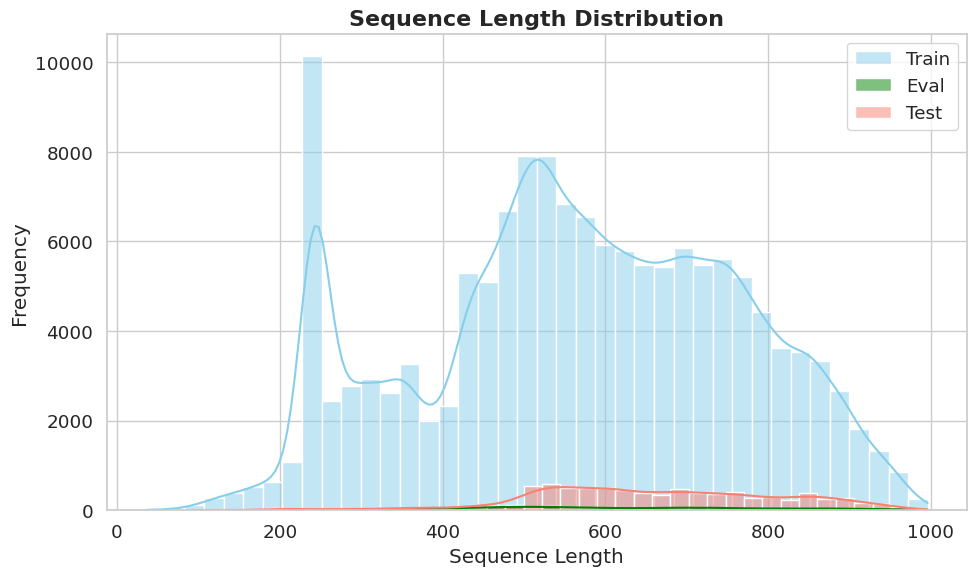

In [40]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.histplot(train_lengths, kde=True, bins=40, color="skyblue", label="Train")
sns.histplot(eval_lengths, kde=True, bins=40, color="green", label="Eval")
sns.histplot(test_lengths, kde=True, bins=40, color="salmon", label="Test")

plt.title("Sequence Length Distribution", fontsize=16, weight="bold")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
llm.train(
  train_dataset=train_dataset,
  params=TrainParams(
    epochs=5,
    batch_size=4,
    gradient_accumulation=4,
    lr=3e-5
	),
  eval_dataset=eval_dataset
)

2026-01-12 16:52:00,354 - INFO - Preparing train dataset...
100%|██████████| 144384/144384 [07:42<00:00, 312.16it/s]
2026-01-12 17:00:13,859 - INFO - Train dataset prepared!
2026-01-12 17:00:13,860 - INFO - Preparing eval dataset...
100%|██████████| 1465/1465 [00:04<00:00, 299.86it/s]
2026-01-12 17:00:18,959 - INFO - Eval dataset prepared!
2026-01-12 17:00:19,681 - INFO - Starting training...
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,2.671500,1.891627
2,2.531700,1.664845
3,2.391100,1.567389
4,1.860200,1.466680
5,1.644900,1.432145


2026-01-12 23:43:54,469 - INFO - Training complete. You may save the model for later usage.


In [42]:
llm.save_pretrained("GeneFormer-x1")

2026-01-12 23:43:54,590 - INFO - Attempting to save model at 'GeneFormer-x1'
2026-01-12 23:43:59,273 - INFO - Successfully saved at 'GeneFormer-x1'


In [43]:
results = []

for data in tqdm(test_dataset):
	pred = llm.generate(data)
	target = data["protein_sequence"]

	dist = editdistance.eval(pred, target)
	similarity = 1 - dist / max(len(pred), len(target))

	results.append({
		"target": target,
		"pred": pred,
		"edit_dist": dist,
		"similarity": similarity
	})

100%|██████████| 8342/8342 [1:21:50<00:00,  1.70it/s]  


In [44]:
similarities = [r["similarity"] for r in results]
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean similarity: {mean_similarity:.4f} ± {std_similarity:.4f}")

Mean similarity: 0.3183 ± 0.2873


In [45]:
llm.train(
  train_dataset=train_dataset,
  params=TrainParams(
    epochs=5,
    batch_size=4,
    gradient_accumulation=4,
    lr=3e-5
	),
  eval_dataset=eval_dataset
)

2026-01-13 01:05:49,873 - INFO - Preparing train dataset...
100%|██████████| 144384/144384 [07:42<00:00, 311.90it/s]
2026-01-13 01:14:01,128 - INFO - Train dataset prepared!
2026-01-13 01:14:01,129 - INFO - Preparing eval dataset...
100%|██████████| 1465/1465 [00:04<00:00, 302.99it/s]
2026-01-13 01:14:06,190 - INFO - Eval dataset prepared!
2026-01-13 01:14:07,177 - INFO - Starting training...


Epoch,Training Loss,Validation Loss
1,1.107800,1.292577
2,0.917100,1.155698
3,0.877500,1.192719
4,0.847500,1.162042
5,0.827400,1.147992


2026-01-13 07:56:52,384 - INFO - Training complete. You may save the model for later usage.


In [46]:
llm.save_pretrained("GeneFormer-x2")

2026-01-13 07:56:52,582 - INFO - Attempting to save model at 'GeneFormer-x2'
2026-01-13 07:56:57,218 - INFO - Successfully saved at 'GeneFormer-x2'


In [47]:
results = []

for data in tqdm(test_dataset):
	pred = llm.generate(data)
	target = data["protein_sequence"]

	dist = editdistance.eval(pred, target)
	similarity = 1 - dist / max(len(pred), len(target))

	results.append({
		"target": target,
		"pred": pred,
		"edit_dist": dist,
		"similarity": similarity
	})

100%|██████████| 8342/8342 [50:21<00:00,  2.76it/s]  


In [48]:
similarities = [r["similarity"] for r in results]
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean similarity: {mean_similarity:.4f} ± {std_similarity:.4f}")

Mean similarity: 0.3541 ± 0.3436


In [49]:
llm.train(
  train_dataset=train_dataset,
  params=TrainParams(
    epochs=5,
    batch_size=4,
    gradient_accumulation=4,
    lr=3e-5
	),
  eval_dataset=eval_dataset
)

2026-01-13 08:47:19,179 - INFO - Preparing train dataset...
100%|██████████| 144384/144384 [07:39<00:00, 313.95it/s]
2026-01-13 08:55:27,446 - INFO - Train dataset prepared!
2026-01-13 08:55:27,447 - INFO - Preparing eval dataset...
100%|██████████| 1465/1465 [00:04<00:00, 303.08it/s]
2026-01-13 08:55:32,515 - INFO - Eval dataset prepared!
2026-01-13 08:55:33,466 - INFO - Starting training...


Epoch,Training Loss,Validation Loss
1,0.848800,1.198861
2,0.399800,0.710132
3,0.278400,0.572057
4,0.226300,0.484356
5,0.208200,0.414236


2026-01-13 15:39:49,329 - INFO - Training complete. You may save the model for later usage.


In [50]:
llm.save_pretrained("GeneFormer-x3")

2026-01-13 15:39:49,403 - INFO - Attempting to save model at 'GeneFormer-x3'
2026-01-13 15:39:53,937 - INFO - Successfully saved at 'GeneFormer-x3'


In [51]:
results = []

for data in tqdm(test_dataset):
	pred = llm.generate(data)
	target = data["protein_sequence"]

	dist = editdistance.eval(pred, target)
	similarity = 1 - dist / max(len(pred), len(target))

	results.append({
		"target": target,
		"pred": pred,
		"edit_dist": dist,
		"similarity": similarity
	})

100%|██████████| 8342/8342 [43:20<00:00,  3.21it/s]  


In [52]:
similarities = [r["similarity"] for r in results]
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean similarity: {mean_similarity:.4f} ± {std_similarity:.4f}")

Mean similarity: 0.3835 ± 0.3657


In [ ]:
llm.train(
  train_dataset=train_dataset,
  params=TrainParams(
    epochs=5,
    batch_size=4,
    gradient_accumulation=4,
    lr=3e-5
	),
  eval_dataset=eval_dataset
)

llm.save_pretrained("GeneFormer-x4")

results = []

for data in tqdm(test_dataset):
	pred = llm.generate(data)
	target = data["protein_sequence"]

	dist = editdistance.eval(pred, target)
	similarity = 1 - dist / max(len(pred), len(target))

	results.append({
		"target": target,
		"pred": pred,
		"edit_dist": dist,
		"similarity": similarity
	})

2026-01-13 16:51:52,848 - INFO - Preparing train dataset...
100%|██████████| 144384/144384 [07:45<00:00, 310.13it/s]
2026-01-13 17:00:07,498 - INFO - Train dataset prepared!
2026-01-13 17:00:07,499 - INFO - Preparing eval dataset...
100%|██████████| 1465/1465 [00:04<00:00, 300.24it/s]
2026-01-13 17:00:12,600 - INFO - Eval dataset prepared!
2026-01-13 17:00:12,824 - INFO - Starting training...


Epoch,Training Loss,Validation Loss
1,0.198700,0.377265
2,0.160900,0.361556
3,0.143000,0.426206
4,0.131600,0.428033
5,0.125500,0.329459


2026-01-13 23:42:50,991 - INFO - Training complete. You may save the model for later usage.
2026-01-13 23:42:50,993 - INFO - Attempting to save model at 'GeneFormer-x4'
2026-01-13 23:42:55,686 - INFO - Successfully saved at 'GeneFormer-x4'
100%|██████████| 8342/8342 [39:47<00:00,  3.49it/s]  


In [ ]:
llm.train(
  train_dataset=train_dataset,
  params=TrainParams(
    epochs=5,
    batch_size=4,
    gradient_accumulation=4,
    lr=3e-5
	),
  eval_dataset=eval_dataset
)

llm.save_pretrained("GeneFormer-x5")

results = []

for data in tqdm(test_dataset):
	pred = llm.generate(data)
	target = data["protein_sequence"]

	dist = editdistance.eval(pred, target)
	similarity = 1 - dist / max(len(pred), len(target))

	results.append({
		"target": target,
		"pred": pred,
		"edit_dist": dist,
		"similarity": similarity
	})

2026-01-14 00:22:43,122 - INFO - Preparing train dataset...
100%|██████████| 144384/144384 [07:42<00:00, 311.94it/s]
2026-01-14 00:30:54,062 - INFO - Train dataset prepared!
2026-01-14 00:30:54,063 - INFO - Preparing eval dataset...
100%|██████████| 1465/1465 [00:04<00:00, 301.12it/s]
2026-01-14 00:30:59,143 - INFO - Eval dataset prepared!
2026-01-14 00:31:00,018 - INFO - Starting training...


Epoch,Training Loss,Validation Loss
1,0.129200,0.359700
2,0.113500,0.457021
3,0.105200,0.462780
4,0.100400,0.347906
5,0.097600,0.325647


2026-01-14 07:13:36,629 - INFO - Training complete. You may save the model for later usage.
2026-01-14 07:13:36,631 - INFO - Attempting to save model at 'GeneFormer-x5'
2026-01-14 07:13:41,372 - INFO - Successfully saved at 'GeneFormer-x5'
100%|██████████| 8342/8342 [42:33<00:00,  3.27it/s]  


In [57]:
similarities = [r["similarity"] for r in results]
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean similarity: {mean_similarity:.4f} ± {std_similarity:.4f}")

Mean similarity: 0.4354 ± 0.3871


In [58]:
pd.DataFrame(results).to_csv("prediction_results.csv")

In [64]:
vixi = []
for result, raw in zip(results, test_dataset):
  vixi.append({
    **result,
    "organism": raw["organism"],
    "exact_match": int(result["target"] == result["pred"])
	})

In [65]:
from collections import defaultdict

org_to_sims = defaultdict(list)
org_to_exact = defaultdict(list)

for r in vixi:
	org_to_sims[r["organism"]].append(r["similarity"])
	org_to_exact[r["organism"]].append(r["exact_match"])

org_mean_sims = np.array([np.mean(v) for v in org_to_sims.values()])
org_exact_rates = np.array([np.mean(v) for v in org_to_exact.values()])

organism_balanced_metrics = {
	"organism_mean_similarity": float(np.mean(org_mean_sims)),
	"organism_median_similarity": float(np.median(org_mean_sims)),
	"organism_p75_similarity": float(np.percentile(org_mean_sims, 75)),
	"organism_p90_similarity": float(np.percentile(org_mean_sims, 90)),
	"organism_exact_match_rate": float(np.mean(org_exact_rates))
}

print("\nOrganism-balanced metrics:")
for k, v in organism_balanced_metrics.items():
	print(f"{k}: {v:.4f}")


Organism-balanced metrics:
organism_mean_similarity: 0.8512
organism_median_similarity: 1.0000
organism_p75_similarity: 1.0000
organism_p90_similarity: 1.0000
organism_exact_match_rate: 0.7690


In [82]:
import numpy as np
from collections import defaultdict

def compute_metrics_from_similarities(similarities: list[float], exact_matches: list[int]) -> dict[str, float]:
	sims = np.array(similarities, dtype=float)
	exacts = np.array(exact_matches, dtype=float)

	return {
		"n": int(len(sims)),
		"mean": float(np.mean(sims)) if len(sims) else float("nan"),
		"std": float(np.std(sims)) if len(sims) else float("nan"),
		"median": float(np.median(sims)) if len(sims) else float("nan"),
		"p75": float(np.percentile(sims, 75)) if len(sims) else float("nan"),
		"p90": float(np.percentile(sims, 90)) if len(sims) else float("nan"),
		"exact_match_rate": float(np.mean(exacts)) if len(exacts) else float("nan"),
	}

# 1) Métrica normal (todas as sequências)
all_metrics = compute_metrics_from_similarities(
	[r["similarity"] for r in vixi],
	[r["exact_match"] for r in vixi]
)

# 2) Métrica deduplicada por target (cada proteína-alvo única conta uma vez)
# Estratégia: manter o "melhor" resultado para cada target (ou o primeiro). Eu recomendo "melhor similarity".
best_by_target: dict[str, dict] = {}

for r in vixi:
	t = r["target"]
	if t not in best_by_target or r["similarity"] > best_by_target[t]["similarity"]:
		best_by_target[t] = r

unique_target_results = list(best_by_target.values())

unique_target_metrics = compute_metrics_from_similarities(
	[r["similarity"] for r in unique_target_results],
	[r["exact_match"] for r in unique_target_results]
)

print("All (sequence-weighted):", all_metrics)
print("Unique target:", unique_target_metrics)

# 3) Diagnóstico: quão repetido é o target no teste?
target_counts = defaultdict(int)
for r in vixi:
	target_counts[r["target"]] += 1

counts = np.array(list(target_counts.values()), dtype=int)
print("\nTarget repetition diagnostics:")
print("unique targets:", len(target_counts))
print("total sequences:", len(vixi))
print("median occurrences per target:", int(np.median(counts)))
print("p90 occurrences per target:", int(np.percentile(counts, 90)))
print("max occurrences for a target:", int(np.max(counts)))


All (sequence-weighted): {'n': 8342, 'mean': 0.435435434787735, 'std': 0.38710505511669274, 'median': 0.20774225774225774, 'p75': 1.0, 'p90': 1.0, 'exact_match_rate': 0.25065931431311433}
Unique target: {'n': 6162, 'mean': 0.3170788153887219, 'std': 0.31295911080685074, 'median': 0.17251642036124798, 'p75': 0.4493974922651034, 'p90': 0.9717577139135395, 'exact_match_rate': 0.08941901979876664}

Target repetition diagnostics:
unique targets: 6162
total sequences: 8342
median occurrences per target: 1
p90 occurrences per target: 1
max occurrences for a target: 265


In [78]:
compute_metrics_from_similarities(org_to_sims, org_to_exact)

NameError: name 'compute_metrics_from_similarities' is not defined

In [77]:
import numpy as np
from collections import defaultdict

org_counts = defaultdict(int)
for r in vixi:
	org_counts[r["organism"]] += 1

vals = np.array(list(org_counts.values()), dtype=int)

print("Organisms in test:", len(vals))
print("Seqs per organism - median:", int(np.median(vals)))
print("Seqs per organism - p75:", int(np.percentile(vals, 75)))
print("Seqs per organism - p90:", int(np.percentile(vals, 90)))
print("Seqs per organism - max:", int(np.max(vals)))

# Faixas (bins) úteis para paper
bins = {
	"1": int(np.sum(vals == 1)),
	"2-5": int(np.sum((vals >= 2) & (vals <= 5))),
	"6-20": int(np.sum((vals >= 6) & (vals <= 20))),
	">20": int(np.sum(vals > 20)),
}

print("\nBins (#seqs per organism):")
for k, v in bins.items():
	print(f"{k}: {v}")


Organisms in test: 1049
Seqs per organism - median: 1
Seqs per organism - p75: 2
Seqs per organism - p90: 4
Seqs per organism - max: 2026

Bins (#seqs per organism):
1: 674
2-5: 290
6-20: 62
>20: 23
